In [1]:
import os, sys
sys.path.insert(0, os.environ['PROJECT_PATH'])

In [2]:
from __future__ import print_function
import pandas as pd, textacy

from config.resources import path_to

In [3]:
import matplotlib, matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [4]:
dset_name = 'saras'
jbv_df = pd.read_csv(path_to[dset_name + '_meta'])

In [5]:
jbv_df.dropna(inplace=True, subset=[ 'AB' ])
jbv_df.sort_values('PY', inplace=True)

Number of unique author keywords in corpus: 0


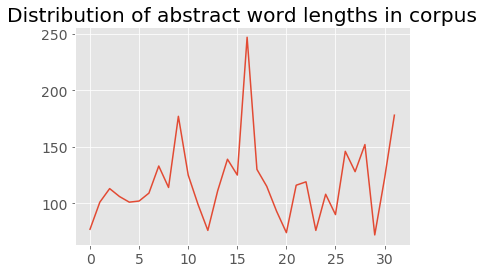

In [6]:
jbv_df['abstract_len'] = jbv_df['AB'].dropna().apply(lambda a: len(a.split()))
jbv_df['keyword_ls'] = jbv_df['DE'].dropna().apply(lambda a: a.split(';'))

plt.plot(jbv_df['abstract_len'].tolist())
plt.title('Distribution of abstract word lengths in corpus')

keyword_set = { k for _, row in jbv_df.dropna().iterrows() for k in row['keyword_ls'] }

print('Number of unique author keywords in corpus:', len(keyword_set))

In [7]:
from spacy.lang.en.stop_words import STOP_WORDS
# print(STOP_WORDS)

STOP_WORDS.add('elsevier')

In [8]:
nb_features = 120
# custom_stop_words = ENGLISH_STOP_WORDS.union(set(['elsevier', 'rights', 'reserved'])) 

path_to_corpus = path_to['textacy_corpus'].format(dset_name)
if os.path.exists(path_to_corpus):
    abstracts_corpus = textacy.Corpus.load(path_to_corpus)
else:
    abstract_ls = list(map(lambda s: unicode(s, 'utf-8'), jbv_df.AB.tolist()))
    metadata_ls = [ {'title': row.TI, 'year': row.PY } for _, row in jbv_df.iterrows() ]
    abstracts_corpus = textacy.Corpus(lang=u'en', texts=abstract_ls, metadatas = metadata_ls)
    abstracts_corpus.save(path_to_corpus)
    
tfidf_vectorizer = textacy.Vectorizer(apply_idf=True, norm='l2', min_df=2, max_df=0.95, max_n_terms=nb_features)
terms_ls = [ doc.to_terms_list(filter_stops=True, named_entities=True, as_strings=True, normalize='lemma')\
            for doc in abstracts_corpus ]

tfidf_doc_mat = tfidf_vectorizer.fit_transform(terms_ls)
tfidf_feature_names = tfidf_vectorizer.terms_list

print("Created %d X %d document-term matrix" % (tfidf_doc_mat.shape[0], tfidf_doc_mat.shape[1]))
print("Vocabuliary has %d distinct terms" % len(tfidf_feature_names))

Created 32 X 120 document-term matrix
Vocabuliary has 120 distinct terms


In [9]:
nb_topics = 10 
nmf = textacy.tm.TopicModel('nmf', n_topics=nb_topics)
nmf.fit(tfidf_doc_mat)
doc_topic_mat = nmf.get_doc_topic_matrix(tfidf_doc_mat)

In [10]:
path_to_topic_descriptors = path_to['topic_models'].format(dset_name, str(nb_topics))
f = open(path_to_topic_descriptors, 'w')
for topic_idx, topic_data in nmf.top_topic_terms(tfidf_vectorizer.id_to_term, topics=range(nb_topics), weights = True):
    topic_terms = [ topic_term + '*' + str(round(topic_prob, 2)) for topic_term, topic_prob in topic_data]
    print('topic', topic_idx + 1, ':', ' | '.join(topic_terms))
    print('topic', topic_idx + 1, ':', ' | '.join(topic_terms), file=f)
f.close()

topic 1 : firm*0.65 | performance*0.29 | serial*0.27 | success*0.26 | -PRON-*0.22 | design*0.18 | entrepreneur*0.17 | view*0.13 | entrepreneurial*0.12 | the*0.08
topic 2 : new*0.53 | new market*0.51 | market*0.48 | evolutionary*0.24 | creation*0.16 | change*0.16 | process*0.15 | economic*0.14 | article*0.1 | create*0.1
topic 3 : control*0.35 | venture*0.33 | strategy*0.26 | predictive*0.24 | prediction*0.21 | approach*0.2 | non*0.17 | c*0.12 | firm*0.11 | important*0.1
topic 4 : method*0.6 | way*0.28 | world*0.24 | outline*0.21 | entrepreneurial*0.18 | question*0.14 | term*0.12 | suggest*0.11 | framework*0.11 | research*0.1
topic 5 : effectuation*0.74 | article*0.19 | behavioral*0.18 | logic*0.18 | theory*0.17 | research*0.16 | work*0.15 | in*0.14 | argue*0.13 | empirical*0.13
topic 6 : entrepreneurship*0.48 | contingency*0.4 | research*0.25 | stream*0.23 | in*0.23 | two*0.22 | opportunity*0.21 | review*0.2 | -PRON-*0.19 | study*0.13
topic 7 : simon*0.39 | artificial*0.38 | design*0.33

In [11]:
doc_topic_mat = nmf.get_doc_topic_matrix(tfidf_doc_mat)
for doc_idx, topics in nmf.top_doc_topics(doc_topic_mat, docs=range(5), top_n=3, weights=True):
    topic_descr = [ 'topic_' + str(topic_id) + '* ' + str(round(topic_prob, 2))   for topic_id, topic_prob in topics]
    doc_text_brief = abstracts_corpus[doc_idx].metadata['title']
    print('Doc Descr', doc_idx + 1, ': ', doc_text_brief, '; Top topics: ', topic_descr, '\n')

Doc Descr 1 :  Causation and effectuation: Toward a theoretical shift from economic inevitability to entrepreneurial contingency ; Top topics:  ['topic_4* 0.76', 'topic_2* 0.1', 'topic_0* 0.09'] 

Doc Descr 2 :  Entrepreneurship as a science of the artificial ; Top topics:  ['topic_6* 0.81', 'topic_7* 0.12', 'topic_5* 0.04'] 

Doc Descr 3 :  The economic implications of exaptation ; Top topics:  ['topic_1* 1.0', 'topic_9* 0.0', 'topic_8* 0.0'] 

Doc Descr 4 :  The questions we ask and the questions we care about: reformulating some problems in entrepreneurship research ; Top topics:  ['topic_3* 0.32', 'topic_5* 0.3', 'topic_7* 0.18'] 

Doc Descr 5 :  Making it happen: Beyond theories of the firm to theories of firm design ; Top topics:  ['topic_0* 0.78', 'topic_4* 0.17', 'topic_3* 0.04'] 



In [12]:
import numpy as np, pdb
nb_topics, nb_doc_wts = 6, 3
# top_n_topic_ids = nmf.topic_weights(doc_topic_mat).argsort()[::-1][1:nb_topics + 1]
yr_topic_wts = []
top_n_topic_ids = [ 0, 1, 4, 5, 8, 9 ]
for idx in top_n_topic_ids:
    topics_year_dict = {}
    for i in range(doc_topic_mat.shape[0]):
        doc_yr = abstracts_corpus[i].metadata['year']
        if str(doc_yr) not in topics_year_dict:
            topics_year_dict[str(doc_yr)] = [ doc_topic_mat[i, idx] ]
        else:
            topics_year_dict[str(doc_yr)].append( doc_topic_mat[i, idx] )
    yr_topic_wts.append([ (doc_yr, sum(sorted(doc_wts)[::-1][:nb_doc_wts]) / nb_doc_wts) \
                 for doc_yr, doc_wts in topics_year_dict.items() ])

In [13]:
top_n_topic_ids
len(yr_topic_wts)

6

TypeError: lmplot() takes at least 3 arguments (2 given)

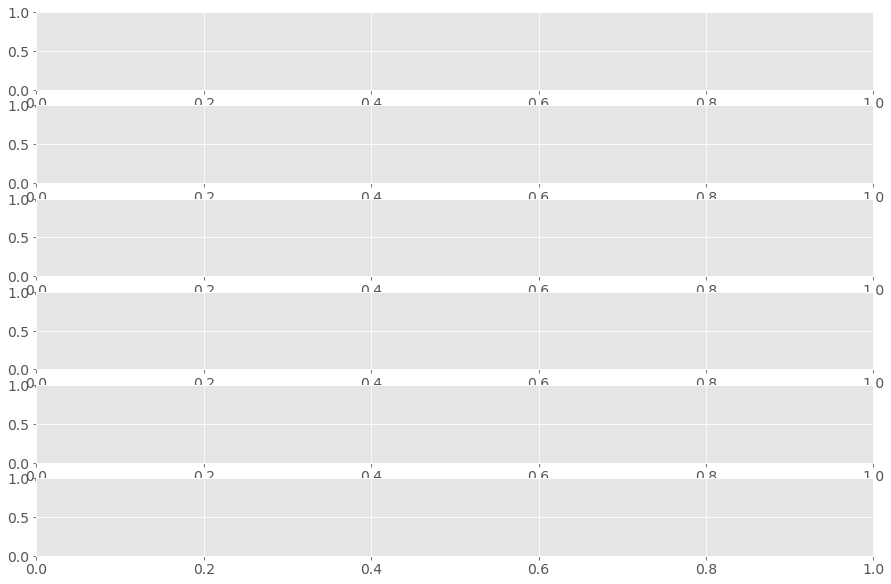

In [20]:
import seaborn as sns

_, axes = plt.subplots(nrows=6, figsize=(15, 10))

topic_names = [ 'Firm performance', 'Creating new markets' , 'Logic of effectuation',
               'Role of contingency', 'Organization', 'Stakeholders' ]
col = [ 'indianred', 'blue', 'green', 'black', 'purple', 'gold' ]
for i in range(len(yr_topic_wts)):
    topic_yrs, topic_wts = zip(*yr_topic_wts[i])
    sns.lmplot(topic_wts, topic_yrs) 

In [14]:
for i, val in enumerate(nmf.topic_weights(doc_topic_mat)):
    print(i, val)

0 0.11950447830615396
1 0.1358432488823154
2 0.10182294982931564
3 0.08056790901279284
4 0.0887204064626343
5 0.13972359489988548
6 0.08521051366204026
7 0.1310031516033453
8 0.06197430546278648
9 0.0556294418787304


In [11]:
from textacy.viz import termite, network
# network.draw_semantic_network()

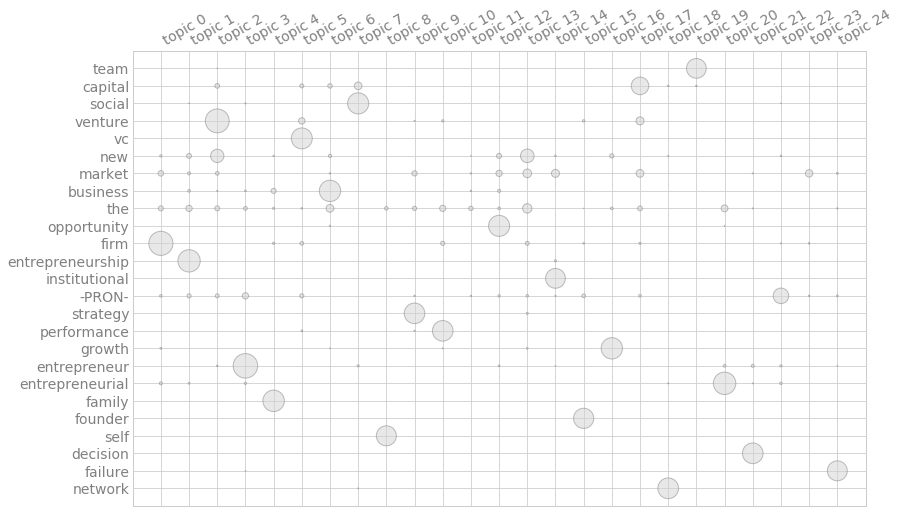

In [75]:
nmf.termite_plot(tfidf_doc_mat, tfidf_vectorizer.id_to_term, topics=-1, n_terms=25, sort_terms_by='seriation')

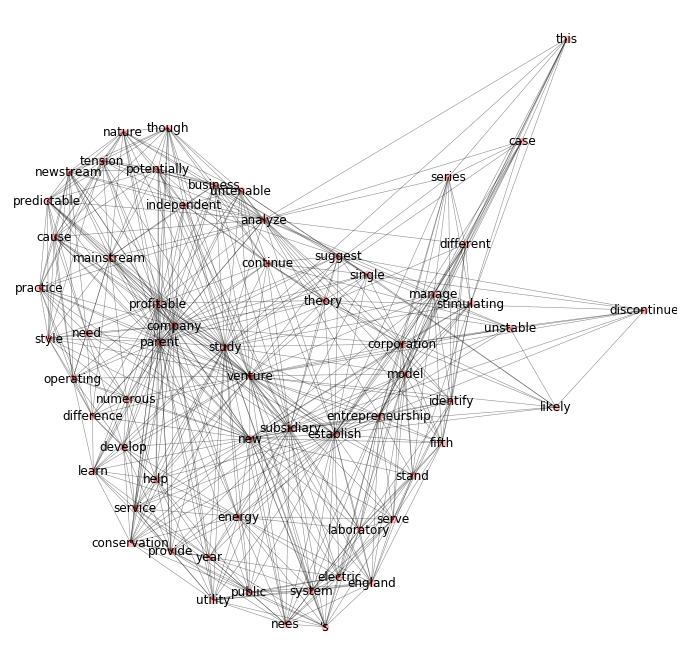

In [50]:
sample_doc = abstracts_corpus[0]
network.draw_semantic_network(sample_doc.to_semantic_network(), draw_nodes = True, 
                              base_node_size = 50, line_alpha = 0.5)

In [17]:
from pickle import dump

dump(doc_topic_mat, open(path_to['doc_term_matrices'].format('jbv'), 'wb'))